In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.feature_selection import VarianceThreshold,mutual_info_classif,SelectKBest,SelectFromModel
from mlxtend.feature_selection import SequentialFeatureSelector

from imblearn.pipeline import make_pipeline

import lightgbm as lgb

from sklearn.model_selection import  GridSearchCV,cross_val_score,TimeSeriesSplit,cross_validate

from time import time

import sklearn.metrics as metrics
from sklearn.metrics import brier_score_loss,confusion_matrix, recall_score, precision_score, roc_auc_score,roc_curve, auc,matthews_corrcoef,make_scorer,accuracy_score, f1_score

/Users/neenu/opt/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [3]:
#reading csv files
X_train=pd.read_csv('X_train_F.csv')
Y_train=pd.read_csv('Y_train_F.csv')
X_test=pd.read_csv('X_test_F.csv')
Y_test=pd.read_csv('Y_test_F.csv')

In [4]:
X_Data=pd.read_csv('X_Data.csv')
Y_Data=pd.read_csv('Y_Data.csv')

In [12]:
X_train= X_train[:70000]
Y_train=Y_train[:70000]

In [6]:
from sklearn.datasets import make_classification
from sklearn.feature_selection import RFECV

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint as sp_randint

In [7]:
from sklearn.pipeline import Pipeline
#LGBM
import lightgbm as lgb

In [8]:
# with default paramter
clf = lgb.LGBMClassifier(class_weight="balanced")
rfecv = RFECV(estimator=clf,  step=1,  scoring = 'roc_auc')
pipeline_lgbm  = Pipeline([('feature_sele',rfecv),('clf',clf)])


In [13]:
pipeline_lgbm .fit(X_train,Y_train.values.ravel())
y_trainpred=pipeline_lgbm .predict_proba(X_train)
y_testpred = pipeline_lgbm .predict_proba(X_test)

In [14]:
# auc with default parameters
print('train auc with default parameter:',roc_auc_score(Y_train,y_trainpred[:,1]))
print('test auc with default parameter:',roc_auc_score(Y_test,y_testpred[:,1]))

train auc with default parameter: 0.9802367525918626
test auc with default parameter: 0.8279211008152119


In [15]:
#  parameters currently used
print('Parameters currently in use:\n')
print(clf.get_params())

Parameters currently in use:

{'boosting_type': 'gbdt', 'class_weight': 'balanced', 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}


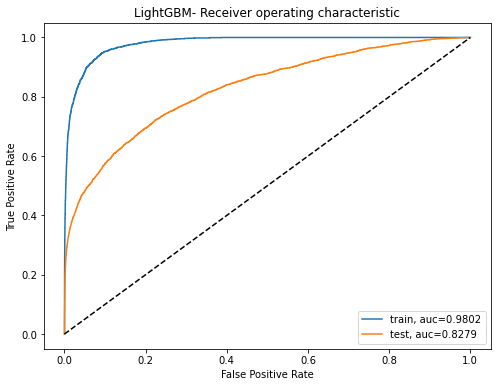

In [16]:
plt.figure(figsize=(8,6))
# auc of train
fpr, tpr, thresh = roc_curve(Y_train,y_trainpred[:,1])
auc = roc_auc_score(Y_train, y_trainpred[:,1])
plt.plot(fpr,tpr,label="train, auc="+str(round(auc,4)))
# auc of test
fpr, tpr, thresh = roc_curve(Y_test, y_testpred[:,1])
auc = roc_auc_score(Y_test,  y_testpred[:,1])
plt.plot(fpr,tpr,label="test, auc="+str(round(auc,4)))
plt.plot([0, 1], [0, 1], 'k--')
plt.legend(loc=0)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('LightGBM- Receiver operating characteristic')
plt.show()

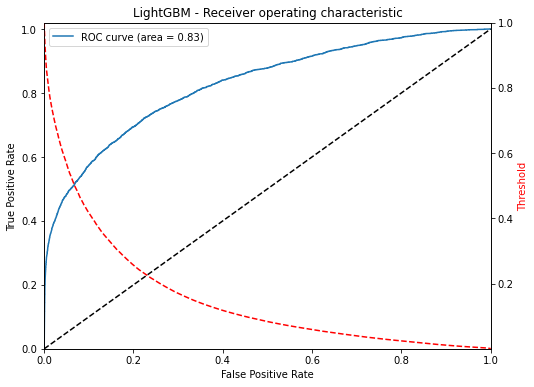

In [17]:
y_scores = y_testpred[:,1]
fpr, tpr, thresholds = roc_curve(Y_test, y_scores)
# auc(fpr, tpr) # auc has been assigned as a variable by the above plot's code
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('LightGBM - Receiver operating characteristic')
plt.legend(loc="best")

# create the axis of thresholds (scores)
ax2 = plt.gca().twinx()
ax2.plot(fpr, thresholds, markeredgecolor='r',linestyle='dashed', color='r')
ax2.set_ylabel('Threshold',color='r')
ax2.set_ylim([thresholds[-1],1])
ax2.set_xlim([fpr[0],fpr[-1]])
plt.show()
# plt.axhline(y=0.0, c="r", ls="--", lw=2)
# plt.axvline(x=4.0, c="r", ls="--", lw=2)

In [20]:
time_splitter_inner = TimeSeriesSplit(n_splits = 3)
time_splitter_outer= TimeSeriesSplit(n_splits = 10)

model=lgb.LGBMClassifier(class_weight="balanced")
params = {"max_depth": [5,10,15],
              "learning_rate" : [0.1,0.15,0.3],
              "num_leaves": [32,150,200],
              "n_estimators": [500,700],
              'boost_from_average': [False],
               "random_state": [2]}                                                  
 
rfecv = RFECV(estimator=model,  step=1,  cv=5,  scoring = 'roc_auc')
gs_lgbm = GridSearchCV(model, param_grid = params, cv = time_splitter_inner, scoring = 'roc_auc',verbose=10, n_jobs=-1)
pipelinelgbm = Pipeline([('feature_sele',rfecv),('clf_cv',gs_lgbm)])

In [21]:
pipelinelgbm .fit(X_Data,Y_Data.values.ravel())

Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   27.4s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   50.0s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed:  6.0min finished


Pipeline(steps=[('feature_sele',
                 RFECV(cv=5, estimator=LGBMClassifier(class_weight='balanced'),
                       scoring='roc_auc')),
                ('clf_cv',
                 GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
                              estimator=LGBMClassifier(class_weight='balanced'),
                              n_jobs=-1,
                              param_grid={'boost_from_average': [False],
                                          'learning_rate': [0.1, 0.15, 0.3],
                                          'max_depth': [5, 10, 15],
                                          'n_estimators': [500, 700],
                                          'num_leaves': [32, 150, 200],
                                          'random_state': [2]},
                              scoring='roc_auc', verbose=10))])

In [22]:
custom_scorer = {
                 'recall': make_scorer(recall_score),
                 'Brier': make_scorer(brier_score_loss),
                 'Matthewscorrcoef': make_scorer(matthews_corrcoef),
                 'ROC_AUC': make_scorer(roc_auc_score)
                 }
lgbm_scores = cross_validate(pipelinelgbm,X_Data,Y_Data.values.ravel(),cv = time_splitter_outer, scoring = custom_scorer)

Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:   25.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   27.7s
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed:   30.0s finished


Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   31.7s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   36.5s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   42.7s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   49.5s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   56.6s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed:  1.2min finished


Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   26.1s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   37.2s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   45.9s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   53.5s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed:  1.9min finished


Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   34.5s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   49.6s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   60.0s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed:  2.6min finished


Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   26.1s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   39.4s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   57.6s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed:  3.0min finished


Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   35.6s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   52.9s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed:  4.1min finished


Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   22.0s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   41.1s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed:  4.8min finished


Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   21.8s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   40.2s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   58.0s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed:  4.8min finished


Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   46.0s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed:  5.5min finished


Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   28.7s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   55.1s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed:  6.7min finished


In [23]:
sorted(lgbm_scores.keys())

['fit_time',
 'score_time',
 'test_Brier',
 'test_Matthewscorrcoef',
 'test_ROC_AUC',
 'test_recall']

In [24]:
lgbm_time = lgbm_scores['fit_time']
lgbm_recall = lgbm_scores['test_recall']
lgbm_Brier = lgbm_scores['test_Brier']
lgbm_Matthewscorrcoef = lgbm_scores['test_Matthewscorrcoef']
lgbm_ROC_AUC = lgbm_scores['test_ROC_AUC']

In [25]:
print("=== fit time ===")
print(lgbm_time)
print("=== All recall Scores ===")
print(lgbm_recall)
print("=== All Brier Scores ===")
print(lgbm_Brier)
print("=== All Matthewscorrcoef Scores ===")
print(lgbm_Matthewscorrcoef)
print("=== All ROC_AUC Scores ===")
print(lgbm_ROC_AUC)

=== fit time ===
[ 79.80135417 139.37027478 195.35691905 250.48691511 294.32651019
 369.8855927  429.87301803 446.7748301  503.96083403 584.70849109]
=== All recall Scores ===
[0.2627451  0.34113712 0.37401575 0.35930736 0.18905473 0.44036697
 0.30078125 0.52066116 0.48809524 0.43877551]
=== All Brier Scores ===
[0.02266227 0.02541254 0.02761276 0.01936194 0.01859186 0.01463146
 0.02189219 0.0149615  0.01188119 0.01485149]
=== All Matthewscorrcoef Scores ===
[0.4472764  0.49551162 0.42216685 0.51033086 0.3991205  0.62291198
 0.48065114 0.66382491 0.6150223  0.57657044]
=== All ROC_AUC Scores ===
[0.63035387 0.66863477 0.6818019  0.67807337 0.59418987 0.71956356
 0.64925863 0.75920038 0.74281471 0.71798231]


In [26]:
print("=== Mean recall Score ===")
print( lgbm_recall.mean())
print("=== Mean Brier Score ===")
print( lgbm_Brier.mean())
print("=== Mean Matthewscorrcoef  Score ===")
print( lgbm_Matthewscorrcoef .mean())
print("=== Mean ROC_AUC  Score ===")
print( lgbm_ROC_AUC .mean())

=== Mean recall Score ===
0.3714940183293227
=== Mean Brier Score ===
0.019185918591859186
=== Mean Matthewscorrcoef  Score ===
0.5233387003367508
=== Mean ROC_AUC  Score ===
0.6841873368749154


In [27]:
print("=== Maximum recall Score ===")
print( lgbm_recall.max())
print("=== Minimum Brier Score ===")
print( lgbm_Brier.min())
print("=== Maximum Matthewscorrcoef  Score ===")
print( lgbm_Matthewscorrcoef .max())
print("=== Maximum ROC_AUC  Score ===")
print( lgbm_ROC_AUC .max())

=== Maximum recall Score ===
0.5206611570247934
=== Minimum Brier Score ===
0.011881188118811881
=== Maximum Matthewscorrcoef  Score ===
0.6638249106609966
=== Maximum ROC_AUC  Score ===
0.7592003795973876
